## Detecção de Anomalias com Controle Estatístico de Processo Multivariado (MSPC)

**Objetivo:** Implementar um sistema de monitoramento de processo multivariado usando Análise de Componentes Principais (PCA) para detectar anomalias sutis que seriam perdidas por métodos de controle univariados.

**Contexto:** Em processos industriais complexos (químicos, farmacêuticos, semicondutores), dezenas ou centenas de variáveis (temperatura, pressão, vazão, etc.) são monitoradas simultaneamente. Essas variáveis são frequentemente **correlacionadas**. Por exemplo, um aumento na temperatura de um reator geralmente causa um aumento na pressão.

**O Problema do Controle Univariado:** Monitorar cada variável com um gráfico de controle individual (ex: Gráfico de Shewhart) é ineficaz. Um processo pode estar fora de controle porque a **relação entre as variáveis mudou**, mesmo que cada variável, individualmente, esteja dentro de seus limites de especificação. 

**A Solução com MSPC e PCA:**
1.  Usamos a **Análise de Componentes Principais (PCA)** para criar um modelo estatístico do processo quando ele está operando em sua condição normal e desejável ("In-Control"). O PCA captura as correlações e as principais fontes de variação.
2.  A partir deste modelo, calculamos duas estatísticas para cada nova observação do processo:
    - **T² de Hotelling:** Mede a variação *dentro* do modelo PCA. Indica quão longe uma observação está do centro dos dados normais. Um T² alto significa uma combinação incomum de eventos que o modelo já conhece.
    - **SPE (Erro de Predição Quadrático) ou Estatística Q:** Mede a variação *fora* do modelo PCA. É o erro ao tentar reconstruir os dados originais a partir do modelo. Um SPE alto indica que algo novo e não modelado está acontecendo, quebrando a estrutura de correlação normal do processo. **É excelente para detectar novas falhas.**
3.  Plotamos essas estatísticas em gráficos de controle. Se qualquer uma delas cruzar um limite pré-definido, um alarme é acionado.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configurações de visualização
plt.rcParams["figure.figsize"] = (16, 5)

### Simulação de um Processo Industrial

Vamos gerar dados para um reator químico com 4 variáveis correlacionadas. A simulação terá duas fases:
- **Fase 1 (Dados de Treino):** 500 amostras de operação normal.
- **Fase 2 (Dados de Monitoramento):** 500 amostras, onde uma falha sutil é introduzida na metade do caminho (amostra 250).

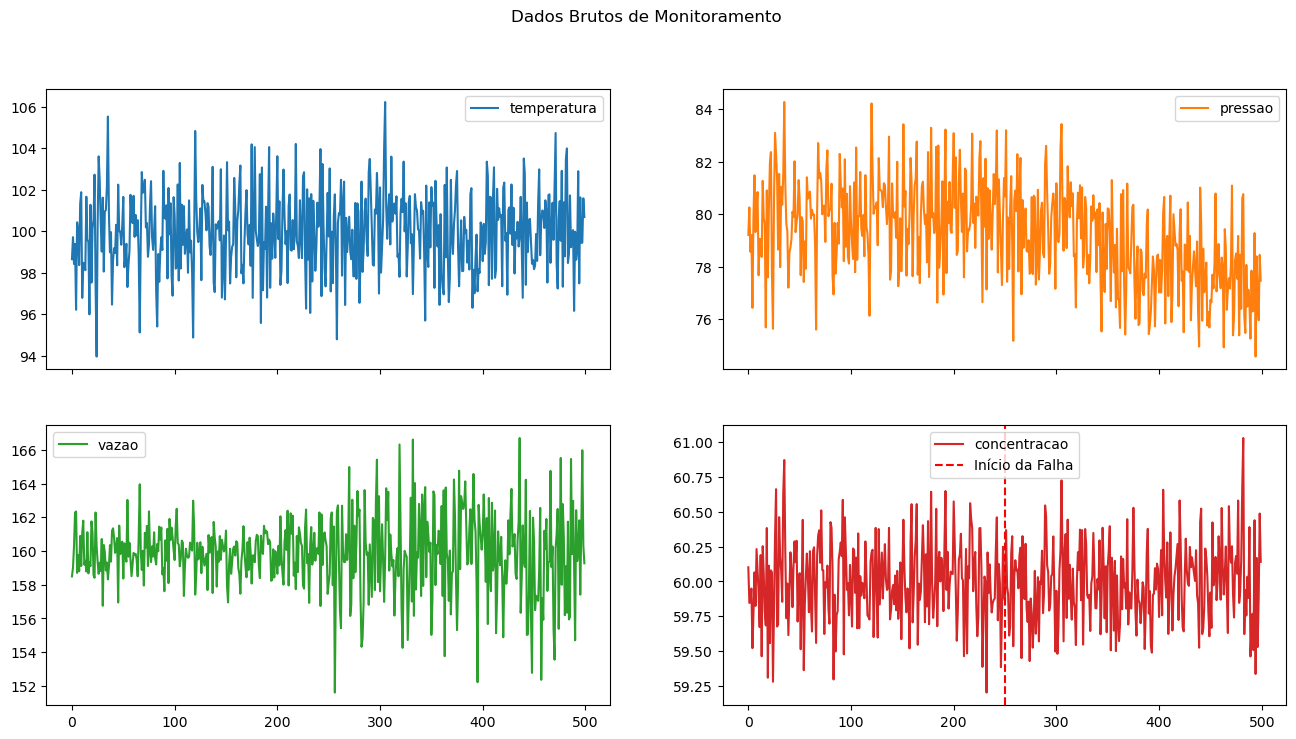

In [2]:
np.random.seed(42)

# --- Fase 1: Dados Normais ('In-Control') para Treinamento ---
n_train = 500
temp_train = np.random.normal(100, 2, n_train)
# Pressão é fortemente correlacionada com a temperatura
press_train = 0.8 * temp_train + np.random.normal(0, 0.5, n_train)
# Vazão é inversamente correlacionada com a pressão
flow_train = 200 - 0.5 * press_train + np.random.normal(0, 1, n_train)
conc_train = 50 + 0.1 * temp_train + np.random.normal(0, 0.2, n_train)

df_train = pd.DataFrame(
    {
        "temperatura": temp_train,
        "pressao": press_train,
        "vazao": flow_train,
        "concentracao": conc_train,
    }
)

# --- Fase 2: Novos Dados para Monitoramento ---
n_test = 500
temp_test = np.random.normal(100, 2, n_test)
press_test = 0.8 * temp_test + np.random.normal(0, 0.5, n_test)
flow_test = 200 - 0.5 * press_test + np.random.normal(0, 1, n_test)
conc_test = 50 + 0.1 * temp_test + np.random.normal(0, 0.2, n_test)

# Introduzindo a falha a partir da amostra 250
fault_start_index = 250
# A falha quebra a correlação: a pressão começa a cair mesmo com a temperatura estável
# e um novo ruído (oscilação) aparece na vazão.
press_test[fault_start_index:] -= np.linspace(0, 3, n_test - fault_start_index)
flow_test[fault_start_index:] += np.random.normal(0, 2.5, n_test - fault_start_index)

df_test = pd.DataFrame(
    {
        "temperatura": temp_test,
        "pressao": press_test,
        "vazao": flow_test,
        "concentracao": conc_test,
    }
)

# Visualizando os dados brutos de monitoramento
df_test.plot(
    subplots=True, layout=(2, 2), figsize=(16, 8), title="Dados Brutos de Monitoramento"
)
plt.axvline(fault_start_index, color="red", linestyle="--", label="Início da Falha")
plt.legend()
plt.show()

**Observação:** Olhando para os gráficos acima, é muito difícil apontar o exato momento em que o processo saiu do controle. As mudanças são sutis e se confundem com o ruído normal do processo. Isso destaca a necessidade de uma abordagem multivariada.

### Construção do Modelo MSPC

Agora, vamos construir o modelo PCA usando **apenas** os dados normais (`df_train`).

In [3]:
# 1. Padronização dos dados (passo CRÍTICO para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)

# 2. Treinamento do modelo PCA
# Vamos escolher o número de componentes que explicam 90% da variância
n_comp = 2
pca = PCA(n_components=n_comp)
pca.fit(X_train_scaled)

print(f"Número de componentes principais escolhidos: {n_comp}")
print(f"Variância explicada acumulada: {pca.explained_variance_ratio_.sum():.2%}")

Número de componentes principais escolhidos: 2
Variância explicada acumulada: 90.54%


### Cálculo dos Limites de Controle

Calculamos T² e SPE para os dados de treino normais para definir os limiares de alarme. Um método comum é usar um percentil alto (ex: 99%) como limite.

In [4]:
# Transforma os dados de treino para o espaço dos PCs
X_train_pca = pca.transform(X_train_scaled)

# Cálculo de T² para os dados de treino
# T² = Σ (t_i^2 / λ_i), onde t_i é o score do PC e λ_i é seu autovalor (variância)
T_squared_train = np.sum(X_train_pca**2 / pca.explained_variance_, axis=1)

# Cálculo de SPE (ou Q) para os dados de treino
# SPE = ||X - X_reconstruido||²
X_train_reconstructed = pca.inverse_transform(X_train_pca)
SPE_train = np.sum((X_train_scaled - X_train_reconstructed) ** 2, axis=1)

# Define os limites de controle (usando o percentil 99)
T_squared_limit = np.percentile(T_squared_train, 99)
SPE_limit = np.percentile(SPE_train, 99)

print(f"Limite de Controle para T² de Hotelling: {T_squared_limit:.2f}")
print(f"Limite de Controle para SPE (Q): {SPE_limit:.2f}")

Limite de Controle para T² de Hotelling: 8.86
Limite de Controle para SPE (Q): 2.52


### Monitoramento em Tempo Real do Novo Processo

Agora, vamos aplicar nosso modelo e limites de controle aos dados de monitoramento (`df_test`) para ver se conseguimos detectar a falha.

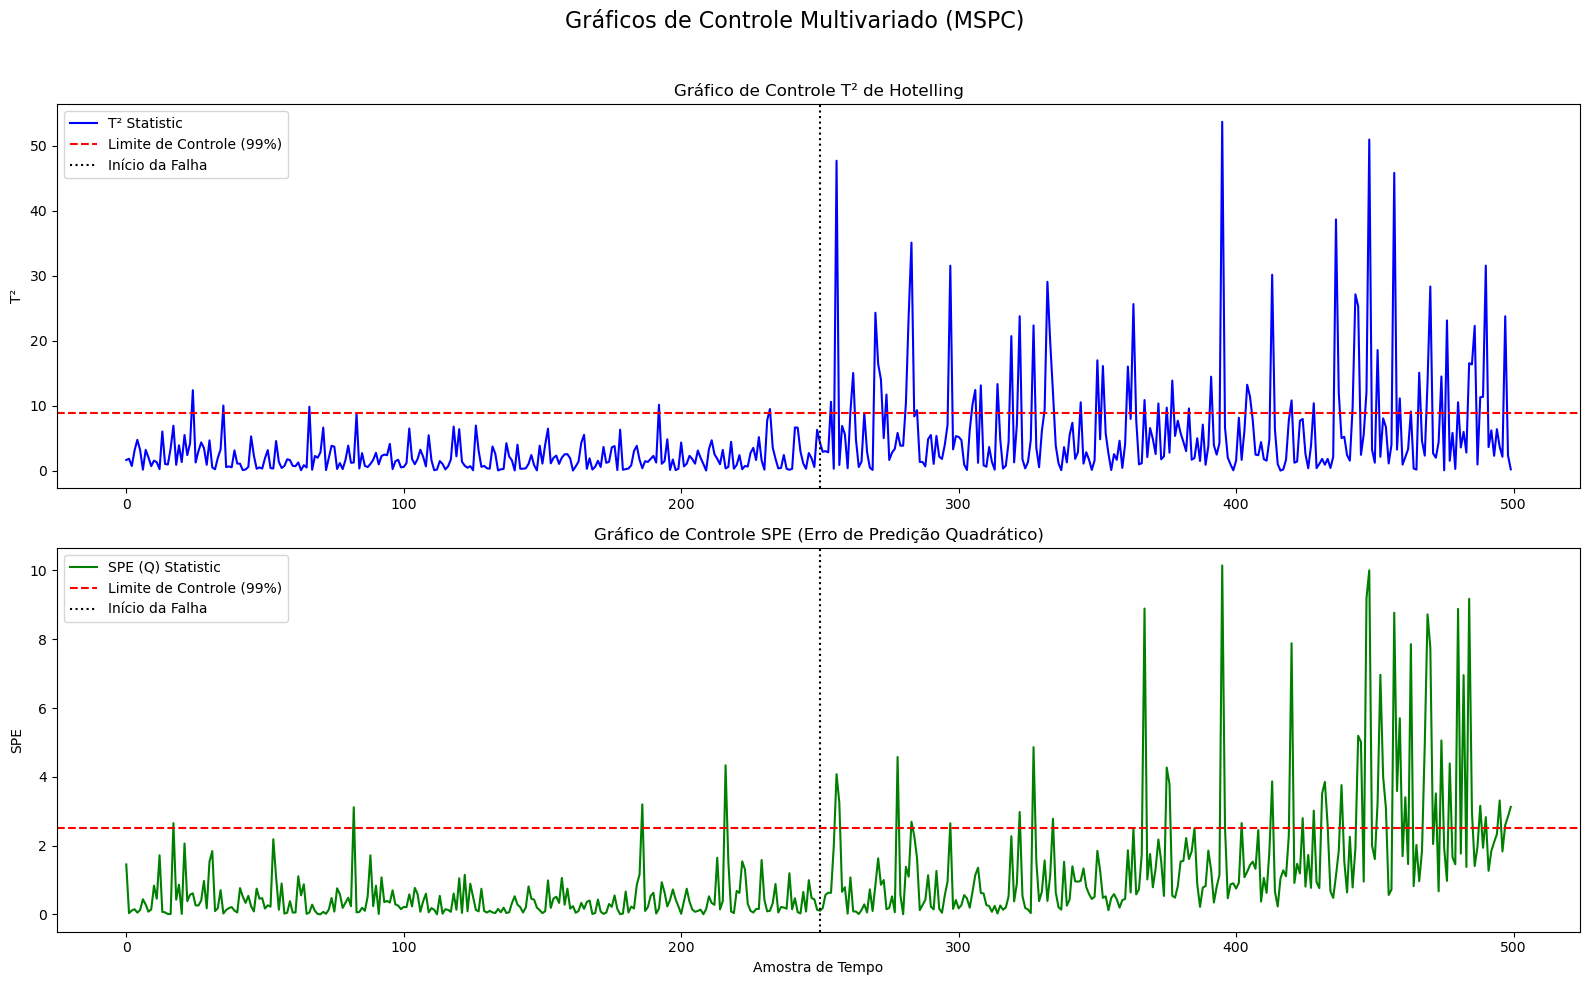

In [5]:
# Padroniza os dados de teste USANDO O MESMO SCALER do treino
X_test_scaled = scaler.transform(df_test)

# Transforma os dados de teste para o espaço dos PCs USANDO O MESMO PCA do treino
X_test_pca = pca.transform(X_test_scaled)

# Calcula T² e SPE para os dados de teste
T_squared_test = np.sum(X_test_pca**2 / pca.explained_variance_, axis=1)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
SPE_test = np.sum((X_test_scaled - X_test_reconstructed) ** 2, axis=1)

# --- Plotando os Gráficos de Controle Multivariado ---
fig, axs = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle("Gráficos de Controle Multivariado (MSPC)", fontsize=16)

# Gráfico para T² de Hotelling
axs[0].plot(T_squared_test, label="T² Statistic", color="blue")
axs[0].axhline(
    T_squared_limit, color="red", linestyle="--", label="Limite de Controle (99%)"
)
axs[0].axvline(fault_start_index, color="black", linestyle=":", label="Início da Falha")
axs[0].set_title("Gráfico de Controle T² de Hotelling")
axs[0].set_ylabel("T²")
axs[0].legend()

# Gráfico para SPE (Q)
axs[1].plot(SPE_test, label="SPE (Q) Statistic", color="green")
axs[1].axhline(SPE_limit, color="red", linestyle="--", label="Limite de Controle (99%)")
axs[1].axvline(fault_start_index, color="black", linestyle=":", label="Início da Falha")
axs[1].set_title("Gráfico de Controle SPE (Erro de Predição Quadrático)")
axs[1].set_xlabel("Amostra de Tempo")
axs[1].set_ylabel("SPE")
axs[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])

### Diagnóstico e Interpretação

**Os resultados são claros e impressionantes!**

1.  **Antes da Falha (Amostras 0-250):** Tanto a estatística T² quanto a SPE permaneceram consistentemente abaixo de seus respectivos limites de controle, indicando que o processo estava operando normalmente, conforme o modelo aprendido.

2.  **Após a Falha (Amostras 250+):**
    - **Gráfico T²:** A estatística T² mostra um leve aumento, com alguns pontos cruzando o limite. Isso indica que a combinação de variáveis está se tornando incomum, mas ainda segue parcialmente a estrutura de correlação aprendida.
    - **Gráfico SPE:** A estatística **SPE dispara e permanece muito acima do seu limite de controle**. Este é o sinal mais forte! Um SPE alto significa que a estrutura de correlação fundamental do processo foi quebrada. Os dados não podem mais ser bem representados pelo modelo PCA da operação normal. Isso nos diz que uma **nova fonte de variação**, não vista antes, entrou no processo - exatamente a nossa falha simulada.

**Conclusão da Análise:** A técnica de MSPC com PCA detectou com sucesso e de forma inequívoca o momento em que a falha sutil começou, algo que era praticamente impossível de ver apenas com a análise das variáveis brutas. O alarme no gráfico SPE, em particular, é um indicador poderoso de que o comportamento fundamental do sistema mudou.

### Conclusão Final e Próximos Passos

O Controle Estatístico de Processo Multivariado (MSPC) é uma metodologia essencial para o monitoramento da saúde e da qualidade em processos complexos e modernos.

- **Visão Holística:** Em vez de centenas de gráficos individuais, o MSPC nos fornece dois gráficos poderosos (T² e SPE) que resumem a saúde geral do processo, levando em conta todas as interações entre as variáveis.
- **Detecção Precoce e Sensível:** Ele é capaz de detectar desvios sutis e mudanças na dinâmica do processo muito antes que eles causem problemas de qualidade ou paradas de produção.

**Próximos Passos na Análise de Causa Raiz:**

Uma vez que um alarme é acionado (especialmente um alarme de SPE), o próximo passo é identificar **quais variáveis** estão contribuindo mais para esse desvio. Técnicas como **"Gráficos de Contribuição"** podem ser usadas para decompor o valor do SPE e apontar para as variáveis originais que mais contribuíram para o erro de reconstrução, guiando a equipe de engenharia diretamente para a causa raiz do problema.